In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib

from gpmdm import GPMDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
gpdm_save_name = "gpmdm"

In [3]:
reduced_columns = WALK_TRIALS_TRAIN[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [4]:
walk_train_dfs = [trial.as_dataframe() for trial in WALK_TRIALS_TRAIN]
walk_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in walk_train_dfs]

run_train_dfs = [trial.as_dataframe() for trial in RUN_TRIALS_TRAIN]
run_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in run_train_dfs]


In [5]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [6]:
gpdm = GPMDM(
        D=DOFs,
        d=d,
        n_classes=2,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [7]:
for train_arr in walk_train_arrs[0:6]:
    gpdm.add_data(train_arr, 0)
for train_arr in run_train_arrs[0:6]:
    gpdm.add_data(train_arr, 1)

total_sequences = sum([len(L) for L in gpdm.class_aware_observations_list])
print(f"Total sequences: {total_sequences}")

Total sequences: 12



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 1.0358e+07
Update time: 0.36052751541137695

GPDM Opt. EPOCH: 10
Running loss: 3.3709e+06
Update time: 3.715813159942627

GPDM Opt. EPOCH: 20
Running loss: 1.3992e+06
Update time: 2.0586748123168945

GPDM Opt. EPOCH: 30
Running loss: 6.3761e+05
Update time: 3.5903611183166504

GPDM Opt. EPOCH: 40
Running loss: 3.4056e+05
Update time: 2.1554880142211914

GPDM Opt. EPOCH: 50
Running loss: 2.0028e+05
Update time: 1.785010576248169

GPDM Opt. EPOCH: 60
Running loss: 1.2254e+05
Update time: 1.7192935943603516

GPDM Opt. EPOCH: 70
Running loss: 8.7571e+04
Update time: 1.6062393188476562

GPDM Opt. EPOCH: 80
Running loss: 7.1635e+04
Update time: 1.7222983837127686

GPDM Opt. EPOCH: 90
Running loss: 6.2275e+04
Update time: 1.6822550296783447

GPDM Opt. EPOCH: 100
Running loss: 5.5322e+04
Update time: 1.6342494487762451

GPDM Opt. EPOCH: 110
Running loss: 4.9457e+04
Update time: 1.6196186542510986

GPDM Opt. EPOCH: 120
Running los

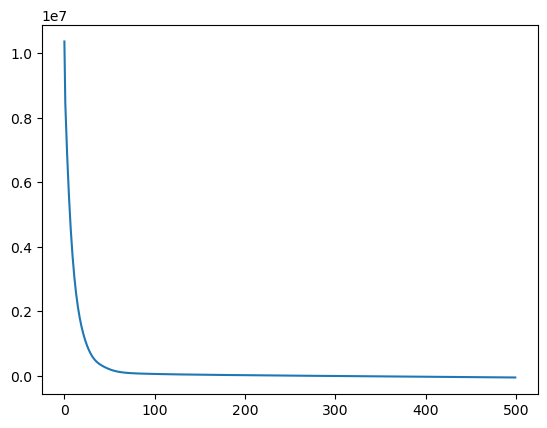

In [8]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=500, num_print_steps=10, lr=0.05)

gpdm.save(f'{gpdm_save_name}_config.pth', f'{gpdm_save_name}_state.pth')  

plt.plot(losses)

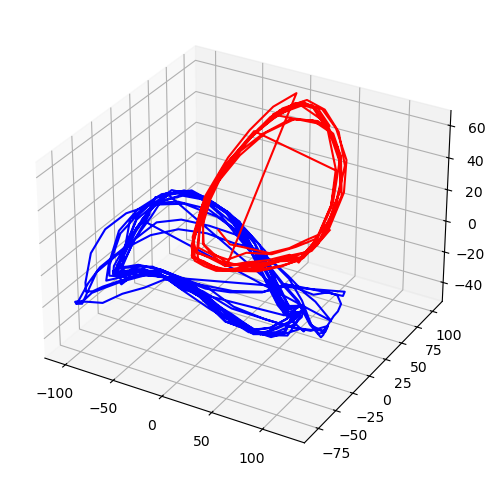

In [9]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()

# plot X0 in blue and X1 in red
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

plt.show()

In [10]:
gpdm.set_evaluation_mode()
_, _, _, latent_map_mse = gpdm.get_latent_map_performance()

print(f"Latent map MSE: {latent_map_mse}")

for i in range(gpdm.n_classes):
    _, _, _, _, dynamics_MSE = gpdm.get_dynamics_map_performance_for_class(i)
    print(f"Class {i} dynamics map MSE: {dynamics_MSE}")


Latent map MSE: 32.95483193277311
Class 0 dynamics map MSE: 9.389724310776943
Class 1 dynamics map MSE: 4.120927318295739


Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: torch.Size([3])
Shape after unsqueeze: torch.Size([1, 3])
Shape of X_generated[i-1, :]: to

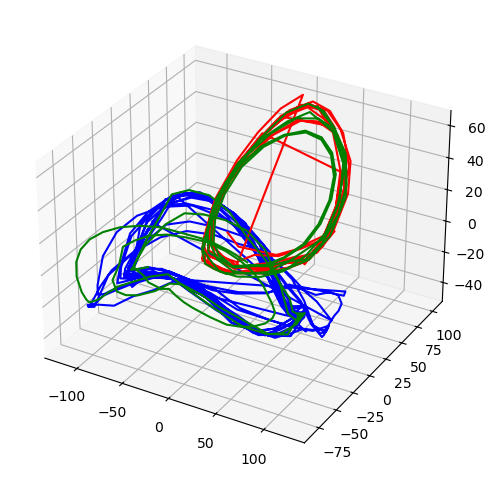

In [11]:
# For each class, pick a random point from the training latent space and generate a sequence

generated = []
for c in range(gpdm.n_classes):
    X0 = gpdm.get_X_for_class(c)
    X0_sample = X0[np.random.randint(X0.shape[0]), :]

    # Generate a sequence
    seq_len = 100
    X_generated = torch.zeros((seq_len, d))
    X_generated[0, :] = X0_sample
    for i in range(1, seq_len):
        print(f"Shape of X_generated[i-1, :]: {X_generated[i-1, :].shape}")         
        print(f"Shape after unsqueeze: {X_generated[i-1, :].unsqueeze(0).shape}")
        X_generated[i, :], _ = gpdm.map_x_dynamics_for_class(X_generated[i-1, :].unsqueeze(0), c)

    generated.append(X_generated.detach().numpy())

# Plot the generated sequence in the latent space in green
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

for c in range(gpdm.n_classes):
    ax.plot(generated[c][:, 0], generated[c][:, 1], generated[c][:, 2], 'g')

    